# 1D Inversion for a Single Sounding

```{admonition} Intermediate notebook
:class: caution
This tutorial focusses on intermediate level functionality within SimPEG. Basic functionality within SimPEG is not discussed in detail, as we assume the user is already familiar. 
```

```{admonition} Light-weight notebook
:class: hint
This tutorial requires minimal computational resources and can be executed quickly in the background while other computer processes are running.
```

**Author:** Devin C. Cowan

</br>

**Keywords:** DC resistivity, 1D sounding, inversion, parametric, sparse norm, apparent resistivity, wires mapping.

</br>

**Summary:** Here we invert DC resistivity data for a single Wenner sounding. We demonstrate 3 approaches that can be used to invert 1D data in SimPEG:

1. A weighted least-squares inversion where the number of layers and their thicknesses are fixed.
2. An iteratively reweighted least-squares (IRLS) inversion to recover sparse and/or blocky structures.
3. A parametric inversion where we invert for the layer thicknesses and electrical properties assuming a 3-layered Earth.

The *weighted least-squares* approach is a great introduction to geophysical inversion with SimPEG. One drawback however, is that it recovers smooth structures which may not be representative of the true model. To recover sparse and/or blocky 1D structures, we demonstrate an *iteratively reweighted least-squares* approach. If the number of layers is known, but their depths, thicknesses and conductivities are not, we can use a *parametric inversion* approach.

</br>

**Learning Objectives:** Because this tutorial focusses primarily on inversion-related functionality, we urge the reader to become familiar with functionality explained in the [1D Forward Simulation of DC Resistivity Data](fwd_dcr_1d.ipynb) tutorial before working through this one. For this tutorial, we focus on:

- General approaches for 1D inversion with SimPEG.
- How to assign appropriate uncertainties to apparent resistivity or normalized voltage data.
- Choosing suitable parameters for the inversion.
- Specifying directives that are applied throughout the inversion.
- Weighted least-squares, sparse-norm and parametric inversion.
- Analyzing inversion outputs.

## Import Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise.
All of the functionality specific to the forward simulation of 1D DC resistivity data are imported from the [simpeg.electromagnetics.static.resistivity](myst:simpeg#simpeg.electromagnetics.static.resistivity) module. Classes required to define the data misfit, regularization, optimization, etc... are imported from elsewhere within SimPEG. We also import some useful utility functions from [simpeg.utils](myst:simpeg#simpeg.utils). To generate the mesh used for the inversion, we use the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG functionality
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.utils import plot_1d_layer_model, download
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)

# discretize functionality
from discretize import TensorMesh

# Basic Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

mpl.rcParams.update({"font.size": 14})

## Download Tutorial Files

For this tutorial, the observed data for the Wenner sounding are stored within a tar-file. Here, we download and extract the data file.

In [2]:
# URL to download from repository assets
data_source = "https://github.com/simpeg/user-tutorials/raw/main/assets/05-dcr/inv_dcr_1d_files.tar.gz"

# download the data
downloaded_data = download(data_source, overwrite=True)

# unzip the tarfile
tar = tarfile.open(downloaded_data, "r")
tar.extractall()
tar.close()

# path to the directory containing our data
dir_path = downloaded_data.split(".")[0] + os.path.sep

# files to work with
data_filename = dir_path + "app_res_1d_data.dobs"

overwriting /home/ssoler/git/user-tutorials/notebooks/05-dcr/inv_dcr_1d_files.tar.gz


   saved to: /home/ssoler/git/user-tutorials/notebooks/05-dcr/inv_dcr_1d_files.tar.gz
Download completed!


## Load and Plot the Data

Here, we load and parse the data file containing observed data and survey geometry. The data file contains the xyz locations for the A, B, M and N electrodes, in order, as well as the observed data. We then compute the AB/2 (half separation distance) and plot the Wenner sounding data.

In [3]:
# Load data
dobs = np.loadtxt(str(data_filename))

In [4]:
# Extract A, B, M and N electrode locations and the observed data
A_electrodes = dobs[:, 0:3]
B_electrodes = dobs[:, 3:6]
M_electrodes = dobs[:, 6:9]
N_electrodes = dobs[:, 9:12]
dobs = dobs[:, -1]

In [5]:
# Compute the AB/2 separation for the 1D Wenner array
AB_separations = np.sqrt(np.sum((A_electrodes - B_electrodes) ** 2, axis=1))

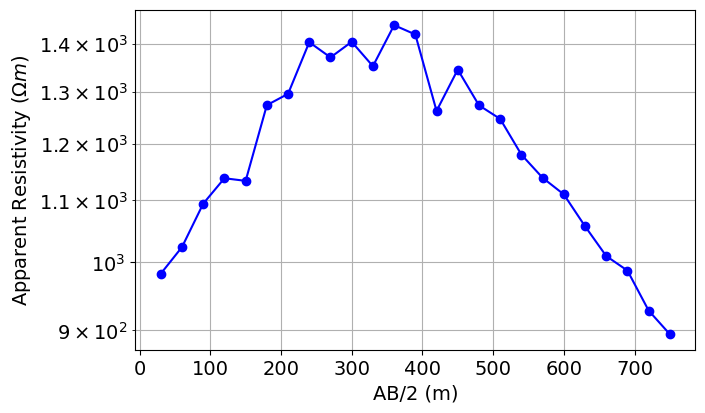

In [6]:
# Plot apparent resistivity as a function of AB/2
fig = plt.figure(figsize=(8, 4))
mpl.rcParams.update({"font.size": 14})
ax1 = fig.add_axes([0.15, 0.1, 0.7, 0.85])
ax1.semilogy(AB_separations / 2, dobs, "b-o")
ax1.grid(which="both")
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
plt.show()

## Assign Uncertainties

Inversion with SimPEG requires that we define the uncertainties on our data; that is, an estimate of the standard deviation of the noise on our data assuming it is uncorrelated Gaussian with zero mean. An online resource explaining uncertainties and their role in the inversion can be found [here](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/Uncertainties.html).

**For 1D apparent resistivity data,** we generally apply a percent uncertainty to all data. A percent uncertainty will fit conductive and resistive structures equally; unlike a floor uncertainty which will prioritize fitting more resistive structures. For this tutorial, we apply a 2% uncertainty to all data. Depending on the quality of the data, we may choose a percent uncertainty between 2% - 10%.

**For 1D normalized voltage data,** we also tend to apply a percent uncertainty to all data. Differences in electrode spacing and subsurface conductivity result in measured voltages that span many orders of magnitude. A percent uncertainty ensures all data are fit equally. Like apparent resistivity, a percent uncertainty of 2% - 10% is a good initial guess.

*NOTE: if the data contain very small values that you feel could be erroneous, a small floor value can be added to ensure stability of the inversion.*

In [7]:
# Add 2.5% uncertainties to all data.
uncertainties = 0.025 * np.abs(dobs)

## Define the Survey

Here, we define the survey geometry. Although the survey consists of a single 1D Wenner sounding, the approach is generalized for 2D and 3D surveys where the electrode locations may not be sorted. For a comprehensive description of constructing DC resistivity surveys in SimPEG, see the [1D Forward Simulation of DC Resistivity Data](fwd_dcr_1d.ipynb) tutorial.

In [8]:
# Sort by unique current electrode locations
unique_tx, k = np.unique(np.c_[A_electrodes, B_electrodes], axis=0, return_index=True)
n_sources = len(k)
k = np.sort(k)
k = np.r_[k, len(k) + 1]

In [9]:
# Define empty list for sources to live
source_list = []

# Loop over all sources
for ii in range(0, n_sources):
    # MN electrode locations for receivers. Each is an (N, 3) numpy array
    M_locations = M_electrodes[k[ii] : k[ii + 1], :]
    N_locations = N_electrodes[k[ii] : k[ii + 1], :]
    receiver_list = [
        dc.receivers.Dipole(
            M_locations,
            N_locations,
            data_type="apparent_resistivity",
        )
    ]

    # AB electrode locations for source. Each is a (1, 3) numpy array
    A_location = A_electrodes[k[ii], :]
    B_location = B_electrodes[k[ii], :]
    source_list.append(dc.sources.Dipole(receiver_list, A_location, B_location))

# Define survey
survey = dc.Survey(source_list)

## Define the Data

The SimPEG [Data](myst:simpeg#simpeg.data.Data) class is required for inversion and connects the observed data, uncertainties and survey geometry.

In [10]:
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)

## Weighted Least-Squares Inversion

Here, we use the weighted least-squares inversion approach to recover the log-conductivities on a 1D layered Earth. We impose no a-priori information about the number of layers (geological units) or their thicknesses. Instead, we define a large number of layers with exponentially increasing thicknesses. And the depth, thickness and electrical properties of the Earth are inferred from the recovered model.

### Design a 1D Layered Earth

When the spacings between the electrodes are small, we are obtaining higher resolution information about the conductivity near the Earth's surface. As a result, we define much thinner layers near the Earth's surface. When the spacings between electrodes are large, we are obtaining lower resolution information about the conductivity at depth. So at depth, we can define layers that are much thicker. The thickness defining the top layer is ultimately determined by the minimum electrode spacing. And the thickness and depth to the lower layer is determined by the largest electrode spacing. The rate at which the layer thicknesses increase with depth is determined by the user.

**For Wenner soundings:** For the 1D Wenner array, the layer thicknesses and largest depth are determined by the AB/2 spacing. A reasonable minimum layer thickness is 10% the minimum AB/2 spacing. And the depth to the bottom layer should be roughly equal to the largest AB/2 spacing.

**For dipole-dipole, pole-dipole, etc...:** For these surveys, the source electrodes AB and receiver electrodes MN are offset from one another. For a particular set of electrodes ABMN, we consider the distance between the average source location and average receiver location. For a dipole-dipole survey, this would be:

$$
d = \Bigg | \frac{\vec{r}_A+\vec{r}_B}{2} - \frac{\vec{r}_M+\vec{r}_N}{2} \Bigg | 
$$

For a pole-dipole survey, this would be:

$$\, 
d = \Bigg | \, \vec{r}_A - \frac{\vec{r}_M+\vec{r}_N}{2} \Bigg | 
$$

Pole sources penetrate the Earth more deeply and produce smoother fields within the source region, so we can get away with a larger layer thickness for the top layer but we need to discretize deeper. But in general, it is easy to make your your top layer equal to 10% of your smallest distance. And to make the depth to the lower layer equal to the largest distance.

In [11]:
# Use Wenner electrode spacings to set discretization parameters
print("AB separations: {}".format(AB_separations))
depth_min = 5.0  # top layer thickness
depth_max = np.max(AB_separations / 2)  # depth to lowest layer
geometric_factor = 1.1  # rate of thickness increase

AB separations: [  60.  120.  180.  240.  300.  360.  420.  480.  540.  600.  660.  720.
  780.  840.  900.  960. 1020. 1080. 1140. 1200. 1260. 1320. 1380. 1440.
 1500.]


In [12]:
# Increase subsequent layer thicknesses by the geometric factors until
# it reaches the maximum layer depth.
layer_thicknesses = [depth_min]
while np.sum(layer_thicknesses) < depth_max:
    layer_thicknesses.append(geometric_factor * layer_thicknesses[-1])

n_layers = len(layer_thicknesses) + 1  # Number of layers

### Define a Model and Mapping

Recall from the [Forward Simulation of 1D Sounding DC Resistivity Data](fwd_dcr_1d.ipynb) tutorial that the 'model' is not necessarily synonymous with physical property values. And that we need to define a mapping from the model to the set of input parameters required by the forward simulation. When inverting to recover electrical resistivities (or conductivities), it is best to use the log-value, as electrical resistivities (or conductivities) of rocks span many order of magnitude.

Here, the model defines the log-resistivity values for a defined set of subsurface layers. And we use the [simpeg.maps.ExpMap](myst:simpeg#simpeg.maps.ExpMap) to map from the model parameters to the resistivity values required by the forward simulation.

In [13]:
log_resistivity_map = maps.ExpMap(nP=n_layers)

### Starting/Reference Models

The **starting model** defines a reasonable starting point for the inversion. Because electromagnetic problems are non-linear, your choice in starting model does have an impact on the recovered model. For DC resistivity inversion, we generally choose our starting model based on apparent resistivities. For the tutorial example, the apparent resistivities were near 1000 $\Omega m$. It should be noted that the starting model **cannot be vector of zeros,** otherwise the inversion will be unable to compute a gradient direction at the first iteration.

The **reference model** is used to include a-priori information. The impact of the reference model on the inversion will be discussed in another tutorial. The reference model for basic inversion approaches is either zero or equal to the starting model.

Notice that the length of the starting and reference models is equal to the number of model parameters!!!

In [14]:
# Starting model is log-resistivity values (Ohmm)
starting_resistivity_model = np.log(1e3 * np.ones(n_layers))

# Reference model is also log-resistivity values (Ohmm)
reference_resistivity_model = starting_resistivity_model.copy()

### Define the Forward Simulation

A simulation object defining the forward problem is required in order to predict data and calculate misfits for recovered models. A comprehensive description of the simulation object for 1D DC resistivity was discussed in the [1D Forward Simulation of DC Resistivity Data for a Single Sounding](fwd_dcr_1d.ipynb) tutorial. Here, we use the [Simulation1DLayers](myst:simpeg#simpeg.electromagnetics.static.resistivity.Simulation1DLayers) which simulates the data according to a 1D Hankel transform solution.

The layer thicknesses are a static property of the simulation, and we set them using the ``thicknessess`` keyword argument. Since our model consists of log-resistivities, we use ``rhoMap`` to set the mapping from the model to the layer resistivities.

In [15]:
simulation_L2 = dc.simulation_1d.Simulation1DLayers(
    survey=survey,
    rhoMap=log_resistivity_map,
    thicknesses=layer_thicknesses,
)

### Define the Data Misfit

To understand the role of the data misfit in the inversion, please visit [this online resource](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/Uncertainties.html).
Here, we use the [L2DataMisfit](myst:simpeg#simpeg.data_misfit.L2DataMisfit) class to define the data misfit. In this case, the data misfit is the L2 norm of the weighted residual between the observed data and the data predicted for a given model. When instantiating the data misfit object within SimPEG, we must assign an appropriate *data object* and *simulation object* as properties.

In [16]:
dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation_L2, data=data_object)

### Define the Regularization

To understand the role of the regularization in the inversion, please visit [this online resource](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/ObjectiveFunction.html). 

To define the regularization within SimPEG, we must define a 1D [tensor mesh](myst:discretize#discretize.TensorMesh). Meshes are designed using the [discretize package](https://discretize.simpeg.xyz). Whereas layer *thicknesses* and our *model* are defined from our top-layer down, tensor meshes are defined from the bottom up. So to define a 1D tensor mesh for the regularization, we:

- add an extra layer to the end of our thicknesses so that the number of cells in the 1D mesh equals the number of model parameters
- reverse the order so that the model parameters in the regularization match up with the appropriate cell
- define the tensor mesh from the cell widths

In [17]:
# Define 1D cell widths
h = np.r_[layer_thicknesses, layer_thicknesses[-1]]
h = np.flipud(h)

# Create regularization mesh
regularization_mesh = TensorMesh([h], "N")
print(regularization_mesh)


  TensorMesh: 31 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     31       -901.79         -0.00      5.00     79.32    1.10




By default, the regularization acts on the model parameters. In this case, the model parameters are the log-resistivities, not the electric resistivities!!! Here, we use the [WeightedLeastSquares](myst:simpeg#simpeg.regularization.WeightedLeastSquares) regularization class to constrain the inversion result. Here, length scale along x are used to balance the smallness and smoothness terms; yes, x is smoothness along the vertical direction. And the reference model is only applied to the smallness term. If we wanted to apply the regularization to a function of the model parameters, we would need to set an approprate mapping object using the ``mapping`` keyword argument.

In [18]:
reg_L2 = regularization.WeightedLeastSquares(
    regularization_mesh,
    length_scale_x=1.0,
    reference_model=reference_resistivity_model,
    reference_model_in_smooth=False,
)

### Define the Optimization Algorithm

Here, we use the [InexactGaussNewton](myst:simpeg#simpeg.optimization.InexactGaussNewton) class to solve the optimization problem using the inexact Gauss Newton with conjugate gradient solver. Reasonable default values have generally been set for the properties of each optimization class. However, the user may choose to set custom values; e.g. the accuracy tolerance for the conjugate gradient solver or the number of line searches.

In [19]:
opt_L2 = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

### Define the Inverse Problem

We use the [BaseInvProblem](myst:simpeg#simpeg.inverse_problem.BaseInvProblem) class to fully define the inverse problem that is solved at each beta (trade-off parameter) iteration. The inverse problem requires appropriate *data misfit*, *regularization* and *optimization* objects.

In [20]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

### Provide Inversion Directives

Directives represent operations that are carried out during the inversion. Here, we apply common directives for weighted least-squares inversion of DC resistivity data and describe their roles. These are:

- [UpdateSensitivityWeights](myst:simpeg#simpeg.directives.UpdateSensitivityWeights): Apply sensitivity weighting to counteract the natural tendency of DC resistivity inversion to place materials near the electrodes. Since the problem is non-linear and the sensitivities are updated with every model, we set `every_iteration=True`.

- [UpdatePreconditioner](myst:simpeg#simpeg.directives.UpdatePreconditioner): Apply Jacobi preconditioner when solving optimization problem to reduce the number of conjugate gradient iterations. We set `update_every_iteration=True` because the ideal preconditioner is model-dependent.

- [BetaEstimate_ByEig](myst:simpeg#simpeg.directives.BetaEstimate_ByEig): Compute and set starting trade-off parameter (beta) based on largest eigenvalues.

- [BetaSchedule](myst:simpeg#simpeg.directives.BetaSchedule): Size reduction of the trade-off parameter at every beta iteration, and the number of Gauss-Newton iterations for each beta. In general, a `coolingFactor` between 1.5 and 2.5, and `coolingRate` of 2 or 3 works well for DC resistivity inversion. Cooling beta too quickly will result in portions of the model getting trapped in local minima. And we will not be finding the solution that minimizes the optimization problem if the cooling rate is too small.

- [TargetMisfit](myst:simpeg#simpeg.directives.TargetMisfit): Terminates the inversion when the data misfit equals the target misfit. A `chifact=1` terminates the inversion when the data misfit equals the number of data.


The directive objects are organized in a ``list``. Upon starting the inversion or updating the recovered model at each iteration, the inversion will call each directive within the list **in order**. The order of the directives matters, and SimPEG will throw an error if directives are organized into an improper order. Some directives, like the ``BetaEstimate_ByEig`` are only used when starting the inversion. Other directives, like ``UpdatePreconditionner``, are used whenever the model is updated.

In [21]:
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=True)
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=2)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [
    sensitivity_weights,
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
]

### Define and Run the Inversion

We define the inversion using the [BaseInversion](myst:simpeg#simpeg.inversion.BaseInversion) class. The inversion class must be instantiated with an appropriate *inverse problem* object and *directives list*. The ``run`` method, along with a starting model, is respondible for running the inversion. The output is a 1D numpy.ndarray containing the recovered model parameters

In [22]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
recovered_model_L2 = inv_L2.run(starting_resistivity_model)


                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayers problem***
                        


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


   0  4.41e+02  1.42e+03  0.00e+00  1.42e+03    1.88e+03      0              
   1  4.41e+02  1.07e+03  3.43e-01  1.22e+03    4.70e+01      0              


   2  2.20e+02  1.07e+03  3.59e-01  1.15e+03    7.54e+02      0   Skip BFGS  
   3  2.20e+02  8.81e+02  9.69e-01  1.09e+03    2.35e+01      0              


   4  1.10e+02  8.77e+02  9.89e-01  9.86e+02    6.30e+02      0   Skip BFGS  
   5  1.10e+02  6.85e+02  2.27e+00  9.35e+02    1.92e+01      0              


   6  5.51e+01  6.82e+02  2.29e+00  8.08e+02    4.84e+02      0   Skip BFGS  
   7  5.51e+01  5.09e+02  4.67e+00  7.66e+02    1.82e+01      0              


   8  2.75e+01  5.10e+02  4.64e+00  6.38e+02    3.48e+02      0              
   9  2.75e+01  3.61e+02  8.97e+00  6.08e+02    2.47e+01      0              


  10  1.38e+01  3.69e+02  8.66e+00  4.88e+02    2.42e+02      0              
  11  1.38e+01  2.45e+02  1.63e+01  4.69e+02    3.29e+01      0              


  12  6.89e+00  2.57e+02  1.52e+01  3.62e+02    1.65e+02      0              
  13  6.89e+00  1.61e+02  2.79e+01  3.53e+02    4.04e+01      0              


  14  3.44e+00  1.75e+02  2.52e+01  2.62e+02    1.11e+02      0              
  15  3.44e+00  1.06e+02  4.49e+01  2.60e+02    4.62e+01      0              


  16  1.72e+00  1.19e+02  3.96e+01  1.87e+02    7.38e+01      0              
  17  1.72e+00  7.14e+01  6.84e+01  1.89e+02    5.06e+01      0              


  18  8.61e-01  8.21e+01  5.92e+01  1.33e+02    4.80e+01      0              
  19  8.61e-01  5.09e+01  9.98e+01  1.37e+02    5.37e+01      0              


  20  4.30e-01  5.88e+01  8.53e+01  9.55e+01    3.00e+01      0              
  21  4.30e-01  3.89e+01  1.33e+02  9.61e+01    5.28e+01      0              


  22  2.15e-01  4.27e+01  1.23e+02  6.92e+01    1.66e+01      0              
  23  2.15e-01  3.16e+01  1.51e+02  6.41e+01    3.94e+01      0              


  24  1.08e-01  3.15e+01  1.49e+02  4.75e+01    9.30e+00      0              
  25  1.08e-01  2.65e+01  1.72e+02  4.50e+01    2.96e+01      0              


  26  5.38e-02  2.64e+01  1.71e+02  3.56e+01    4.31e+00      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.4241e+02
1 : |xc-x_last| = 4.9044e-01 <= tolX*(1+|x0|) = 3.9461e+00
0 : |proj(x-g)-x|    = 4.3125e+00 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 4.3125e+00 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =     100    <= iter          =     27
------------------------- DONE! -------------------------


### Plot Observed and Predicted Data

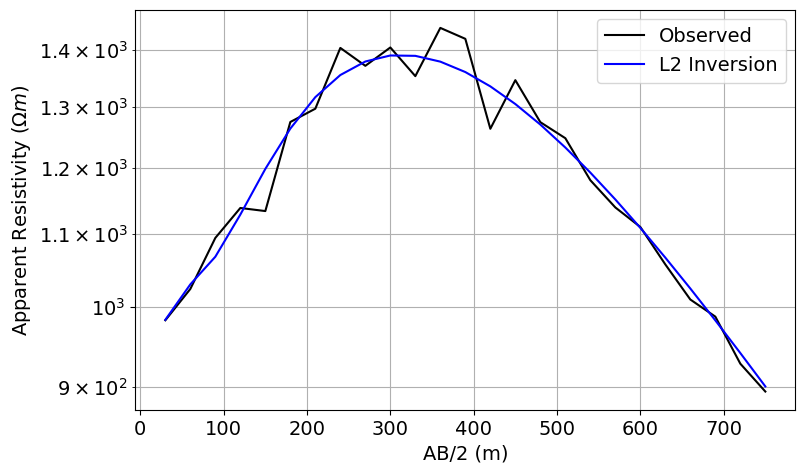

In [23]:
# Plot the true and apparent resistivities on a sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.8])
ax1.semilogy(AB_separations / 2, dobs, "k")
ax1.semilogy(AB_separations / 2, simulation_L2.dpred(recovered_model_L2), "b")
ax1.grid(which="both")
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend(["Observed", "L2 Inversion"])
plt.show()

### Plot the Recovered Model

In [24]:
# Define true model and layer thicknesses
true_resistivities = np.r_[1e3, 4e3, 2e2]
true_layers = np.r_[100.0, 100.0]

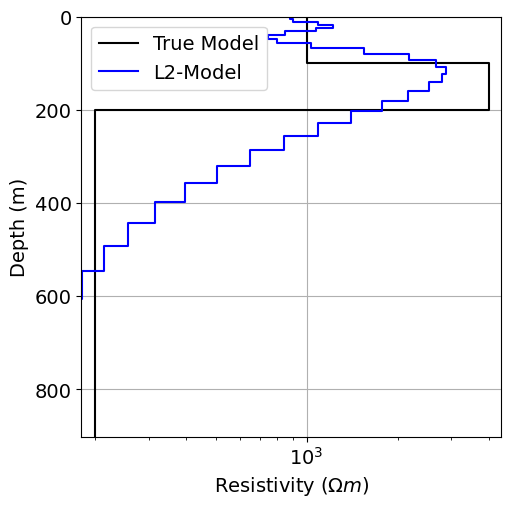

In [25]:
# Plot true model and recovered model
fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
plot_1d_layer_model(true_layers, true_resistivities, ax=ax1, color="k")
plot_1d_layer_model(
    layer_thicknesses, log_resistivity_map * recovered_model_L2, ax=ax1, color="b"
)
x_min, x_max = true_resistivities.min(), true_resistivities.max()
ax1.set_xlim(0.9 * x_min, 1.1 * x_max)
ax1.grid()
ax1.set_xlabel(r"Resistivity ($\Omega m$)")
ax1.legend(["True Model", "L2-Model"])
plt.show()

## Iteratively Re-weighted Least-Squares Inversion

Here, we use the iteratively reweighted least-squares (IRLS) inversion approach to recover sparse and/or blocky models on the set layers.

### Define the Forward Simulation

In [26]:
simulation_irls = dc.simulation_1d.Simulation1DLayers(
    survey=survey,
    rhoMap=log_resistivity_map,
    thicknesses=layer_thicknesses,
)

### Define the Data Misfit

In [27]:
dmis_irls = data_misfit.L2DataMisfit(simulation=simulation_irls, data=data_object)

### Define the Regularization

Here, we use the [Sparse](myst:simpeg#simpeg.regularization.Sparse) regularization class to constrain the inversion result using an IRLS approach. Here, the scaling constants that balance the smallness and smoothness terms are set directly. Equal emphasis on smallness and smoothness is generally applied by using the inverse square of the smallest cell dimension. The reference model is only applied to the smallness term; which is redundant for the tutorial example since we have set the reference model to an array of zeros. Here, we apply a 1-norm to the smallness term and a 1-norm to first-order smoothness along the x (vertical direction).

In [28]:
reg_irls = regularization.Sparse(
    regularization_mesh,
    alpha_s=0.1,
    alpha_x=1,
    reference_model_in_smooth=False,
    norms=[1.0, 1.0],
)

### Define the Optimization Algorithm

In [29]:
opt_irls = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=30, tolCG=1e-3
)

### Define the Inverse Problem

In [30]:
inv_prob_irls = inverse_problem.BaseInvProblem(dmis_irls, reg_irls, opt_irls)

### Provide Inversion Directives

Here, we create common directives for IRLS inversion of DC resistivity data and describe their roles. In additon to the [UpdateSensitivityWeights](myst:simpeg#simpeg.directives.UpdateSensitivityWeights), [UpdatePreconditioner](myst:simpeg#simpeg.directives.UpdatePreconditioner) and [BetaEstimate_ByEig](myst:simpeg#simpeg.directives.BetaEstimate_ByEig)  directives (described before), inversion with sparse-norms requires the [Update_IRLS](myst:simpeg#simpeg.directives.Update_IRLS) directive.

You will notice that we don't use the [BetaSchedule](myst:simpeg#simpeg.directives.BetaSchedule) and [TargetMisfit](myst:simpeg#simpeg.directives.TargetMisfit) directives. Here, the beta cooling schedule is set in the [Update_IRLS](myst:simpeg#simpeg.directives.Update_IRLS) directive using the `coolingFactor` and `coolingRate` properties. The target misfit for the L2 portion of the IRLS approach is set with the `chifact_start` property. 

In [31]:
sensitivity_weights_irls = directives.UpdateSensitivityWeights(every_iteration=True)
starting_beta_irls = directives.BetaEstimate_ByEig(beta0_ratio=1)
update_jacobi_irls = directives.UpdatePreconditioner(update_every_iteration=True)
update_irls = directives.Update_IRLS(
    coolingFactor=2,
    coolingRate=2,
    f_min_change=1e-4,
    max_irls_iterations=30,
    chifact_start=1.0,
)

directives_list_irls = [
    update_irls,
    sensitivity_weights_irls,
    starting_beta_irls,
    update_jacobi_irls,
]

### Define and Run the Inversion

In [32]:
# Here we combine the inverse problem and the set of directives
inv_irls = inversion.BaseInversion(inv_prob_irls, directives_list_irls)

# Run the inversion
recovered_model_irls = inv_irls.run(starting_resistivity_model)

simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayers problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


   0  9.89e+02  1.42e+03  0.00e+00  1.42e+03    1.88e+03      0              
   1  9.89e+02  6.60e+02  2.51e-01  9.08e+02    4.48e+01      0              


   2  4.94e+02  6.53e+02  2.58e-01  7.81e+02    4.61e+02      0   Skip BFGS  
   3  4.94e+02  4.84e+02  5.20e-01  7.40e+02    1.89e+01      0              


   4  2.47e+02  4.86e+02  5.14e-01  6.13e+02    3.30e+02      0              
   5  2.47e+02  3.41e+02  9.89e-01  5.85e+02    2.60e+01      0              


   6  1.24e+02  3.49e+02  9.50e-01  4.66e+02    2.28e+02      0              
   7  1.24e+02  2.29e+02  1.78e+00  4.49e+02    3.43e+01      0              


   8  6.18e+01  2.42e+02  1.65e+00  3.44e+02    1.55e+02      0              
   9  6.18e+01  1.51e+02  3.02e+00  3.37e+02    4.15e+01      0              


  10  3.09e+01  1.65e+02  2.71e+00  2.49e+02    1.04e+02      0              
  11  3.09e+01  9.90e+01  4.81e+00  2.48e+02    4.71e+01      0              


  12  1.54e+01  1.12e+02  4.22e+00  1.77e+02    6.91e+01      0              
  13  1.54e+01  6.74e+01  7.28e+00  1.80e+02    5.12e+01      0              


  14  7.72e+00  7.76e+01  6.28e+00  1.26e+02    4.47e+01      0              
  15  7.72e+00  4.86e+01  1.06e+01  1.30e+02    5.41e+01      0              


  16  3.86e+00  5.60e+01  9.01e+00  9.08e+01    2.78e+01      0              
  17  3.86e+00  3.75e+01  1.36e+01  8.98e+01    5.20e+01      0              


  18  1.93e+00  4.03e+01  1.27e+01  6.48e+01    1.52e+01      0              
  19  1.93e+00  3.05e+01  1.54e+01  6.03e+01    3.81e+01      0              


  20  9.66e-01  3.03e+01  1.52e+01  4.50e+01    8.24e+00      0              
  21  9.66e-01  2.60e+01  1.75e+01  4.29e+01    2.84e+01      0              


  22  4.83e-01  2.59e+01  1.74e+01  3.42e+01    3.75e+00      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
irls_threshold 2.2650827460972094
  23  4.83e-01  2.41e+01  2.61e+01  3.66e+01    2.62e+01      0              


  24  4.83e-01  2.51e+01  2.92e+01  3.92e+01    3.69e+01      0              
  25  4.83e-01  2.53e+01  3.34e+01  4.14e+01    7.98e+00      0   Skip BFGS  


  26  4.83e-01  2.59e+01  3.87e+01  4.45e+01    8.50e+00      0   Skip BFGS  
  27  4.83e-01  2.67e+01  4.50e+01  4.84e+01    9.66e+00      0              


  28  3.99e-01  2.77e+01  5.24e+01  4.86e+01    7.45e+00      0              


  29  3.29e-01  2.77e+01  6.06e+01  4.77e+01    5.34e+00      1   Skip BFGS  
  30  2.73e-01  2.76e+01  7.10e+01  4.70e+01    5.67e+00      1   Skip BFGS  


  31  2.73e-01  2.75e+01  8.30e+01  5.01e+01    8.93e+00      1   Skip BFGS  
  32  2.23e-01  2.83e+01  1.01e+02  5.08e+01    1.05e+01      0              


  33  1.82e-01  2.84e+01  1.20e+02  5.03e+01    4.96e+00      0   Skip BFGS  
  34  1.48e-01  2.83e+01  1.31e+02  4.77e+01    3.12e+00      0   Skip BFGS  


  35  1.23e-01  2.77e+01  1.43e+02  4.52e+01    5.32e+00      0              
  36  1.23e-01  2.71e+01  1.56e+02  4.62e+01    7.58e+00      0   Skip BFGS  


  37  1.23e-01  2.74e+01  1.58e+02  4.68e+01    2.55e+00      0              
  38  1.23e-01  2.75e+01  1.65e+02  4.77e+01    2.63e+00      0   Skip BFGS  


  39  1.01e-01  2.77e+01  1.66e+02  4.45e+01    1.90e+00      0              
  40  1.01e-01  2.70e+01  1.84e+02  4.57e+01    6.85e+00      0              


  41  1.01e-01  2.73e+01  1.76e+02  4.51e+01    9.45e-01      0              
  42  1.01e-01  2.71e+01  1.93e+02  4.67e+01    3.17e+00      0              


  43  1.01e-01  2.75e+01  1.74e+02  4.51e+01    1.24e+00      0              
  44  1.01e-01  2.72e+01  2.06e+02  4.80e+01    5.00e+00      0              


  45  8.37e-02  2.77e+01  1.63e+02  4.14e+01    5.22e+00      0              
  46  8.37e-02  2.66e+01  2.37e+02  4.64e+01    1.94e+01      0              


  47  8.37e-02  2.73e+01  1.54e+02  4.02e+01    3.76e+00      0              
  48  8.37e-02  2.64e+01  2.42e+02  4.66e+01    1.95e+01      0              


  49  8.37e-02  2.73e+01  1.70e+02  4.15e+01    4.52e+00      0              
  50  8.37e-02  2.66e+01  2.33e+02  4.61e+01    1.25e+01      0              


  51  8.37e-02  2.72e+01  1.67e+02  4.12e+01    3.01e+00      0              
  52  8.37e-02  2.65e+01  2.45e+02  4.70e+01    1.35e+01      0              


Reach maximum number of IRLS cycles: 30
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.4241e+02
0 : |xc-x_last| = 7.5270e+00 <= tolX*(1+|x0|) = 3.9461e+00
0 : |proj(x-g)-x|    = 1.3547e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.3547e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =     100    <= iter          =     53
------------------------- DONE! -------------------------


### Plot Observed and Predicted Data

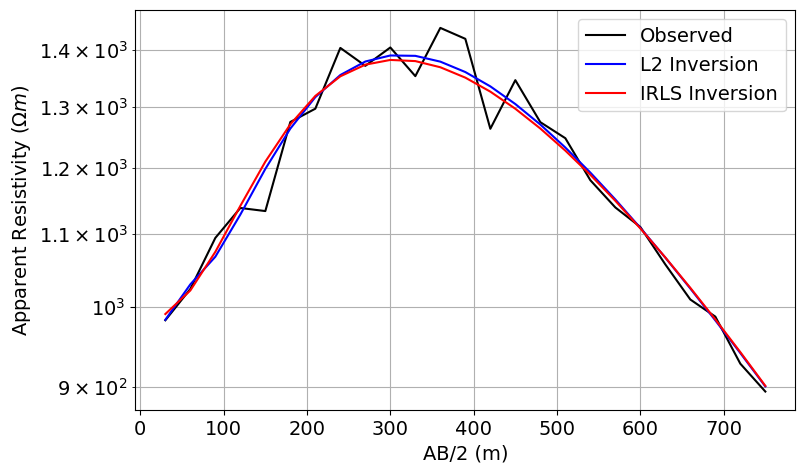

In [33]:
# Plot the true and apparent resistivities on a sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.8])
ax1.semilogy(AB_separations / 2, dobs, "k")
ax1.semilogy(AB_separations / 2, simulation_L2.dpred(recovered_model_L2), "b")
ax1.semilogy(AB_separations / 2, simulation_irls.dpred(recovered_model_irls), "r")
ax1.grid(which="both")
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend(["Observed", "L2 Inversion", "IRLS Inversion"])
plt.show()

### Plot Recovered Models

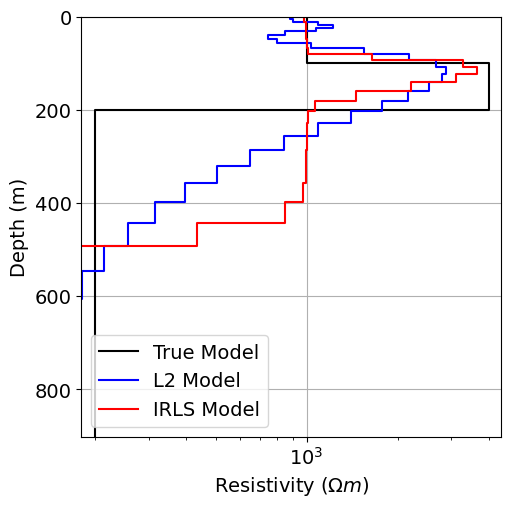

In [34]:
# Plot true model and recovered model
fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
plot_1d_layer_model(true_layers, true_resistivities, ax=ax1, color="k")
plot_1d_layer_model(
    layer_thicknesses, log_resistivity_map * recovered_model_L2, ax=ax1, color="b"
)
plot_1d_layer_model(
    layer_thicknesses, log_resistivity_map * recovered_model_irls, ax=ax1, color="r"
)
x_min, x_max = true_resistivities.min(), true_resistivities.max()
ax1.set_xlim(0.9 * x_min, 1.1 * x_max)
ax1.grid()
ax1.set_xlabel(r"Resistivity ($\Omega m$)")
ax1.legend(["True Model", "L2 Model", "IRLS Model"])
plt.show()

## Parametric Inversion

Here, we assume the subsurface is defined by a 3-layered Earth. However, the electrical properties and thicknesses of the layers are unknown. Here, we define our model to include log-conductivities and log-thicknesses. When including quantities that span different scales, it is frequently best to define the model in terms of log-values so that each quantity influences the predicted data evenly.

### Models and Mappings

For a 3-layered Earth model, the model consists of 2 log-thicknesses and 3 log-conductivities. Similar to the [1D Forward Simulation of DC Resistivity Data](fwd_dcr_1d.ipynb) tutorial, need a mapping that extract log-thicknesses and log-conductivities from the model, and mappings that convert log-values to property values. For this, we require the [simpeg.maps.Wires](myst:simpeg#simpeg.maps.Wires) mapping and [simpeg.maps.ExpMap](myst:simpeg#simpeg.maps.ExpMap) mapping classes. Note that successive mappings can be chained together using the $*$ operator.

In [35]:
# Wire maps to extract log-thicknesses and log-conductivities
wire_map = maps.Wires(("log_thicknesses", 2), ("log_conductivity", 3))

# Maping for layer thicknesses
log_thicknesses_map = maps.ExpMap() * wire_map.log_thicknesses

# Mapping for conductivities
log_conductivity_map = maps.ExpMap() * wire_map.log_conductivity

### Starting and Reference Models

This problem is highly non-linear so it is important to have a reasonable estimate of the true model. 

In [36]:
starting_parametric_model = np.log(np.r_[125.0, 50.0, 1e-3, 2e-3, 5e-2])

reference_parametric_model = starting_parametric_model.copy()

### Define the Forward Simulation

Because the layer thicknesses are part of the model, we define the ``thicknessesMap``. Because we are working in terms of electrical conductivity, we must define the ``sigmaMap``.

In [37]:
simulation_parametric = dc.simulation_1d.Simulation1DLayers(
    survey=survey,
    sigmaMap=log_conductivity_map,
    thicknessesMap=log_thicknesses_map,
)

### Define the Data Misfit

In [38]:
dmis_parametric = data_misfit.L2DataMisfit(
    simulation=simulation_parametric, data=data_object
)

### Define a (Combo) Regularization

We need to define a regularization for each model parameter type. In this case, we have log-thicknesses and log-conductivities. For each model parameter type, we create a 1D [tensor mesh](myst:discretize#discretize.TensorMesh) with length equal to the number of parameters. In the ``mapping`` keyword argument, we used the wire map that extracts the specific model parameters from the model.

Using the $*$ operator, separate regularizations can be summed to form a regularization that is also a [ComboObjectiveFunction](myst:simpeg#simpeg.objective_function.ComboObjectiveFunction). By setting the ``multipliers`` property, we can emphasis the relative contributions of the log-thicknesses and log-conductivities regularizations.

In [39]:
reg_1 = regularization.Smallness(
    TensorMesh([(np.ones(2))], "0"),
    mapping=wire_map.log_thicknesses,
    reference_model=reference_parametric_model,
)

reg_2 = regularization.Smallness(
    TensorMesh([(np.ones(3))], "0"),
    mapping=wire_map.log_conductivity,
    reference_model=reference_parametric_model,
)

reg_parametric = reg_1 + reg_2
reg_parametric.multipliers = [1.0, 0.1]

### Define the Optimization Algorithm

In [40]:
opt_parametric = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

### Define the Inverse Problem

In [41]:
inv_prob_parametric = inverse_problem.BaseInvProblem(
    dmis_parametric, reg_parametric, opt_parametric
)

### Provide Inversion Directives

In [42]:
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=True)
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=2)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_parametric = [
    sensitivity_weights,
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
]

### Define and Run Inversion

In [43]:
inv_parametric = inversion.BaseInversion(
    inv_prob_parametric, directives_list_parametric
)
recovered_model_parametric = inv_parametric.run(starting_parametric_model)


                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayers problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


   0  1.36e+05  1.95e+04  0.00e+00  1.95e+04    1.72e+04      0              
   1  1.36e+05  1.35e+04  2.05e-02  1.63e+04    3.54e+03      0              


   2  6.80e+04  1.24e+04  2.92e-02  1.43e+04    8.80e+03      0   Skip BFGS  
   3  6.80e+04  7.14e+03  1.00e-01  1.39e+04    1.25e+03      0              


   4  3.40e+04  6.83e+03  1.04e-01  1.04e+04    7.29e+03      0   Skip BFGS  
   5  3.40e+04  2.56e+03  2.27e-01  1.03e+04    1.31e+03      0              


   6  1.70e+04  2.75e+03  2.18e-01  6.45e+03    4.95e+03      0              
   7  1.70e+04  8.85e+02  3.22e-01  6.37e+03    9.62e+02      0              


   8  8.51e+03  9.82e+02  3.26e-01  3.76e+03    2.94e+03      0              
   9  8.51e+03  3.41e+02  4.05e-01  3.79e+03    5.31e+02      0              


  10  4.25e+03  3.55e+02  4.29e-01  2.18e+03    1.71e+03      0              
  11  4.25e+03  1.37e+02  4.99e-01  2.26e+03    2.64e+02      0              


  12  2.13e+03  1.38e+02  5.17e-01  1.24e+03    9.95e+02      0              
  13  2.13e+03  6.26e+01  5.76e-01  1.29e+03    1.34e+02      0              


  14  1.06e+03  6.33e+01  5.82e-01  6.82e+02    5.63e+02      0              
  15  1.06e+03  3.67e+01  6.29e-01  7.05e+02    6.75e+01      0              


  16  5.32e+02  3.71e+01  6.29e-01  3.72e+02    3.07e+02      0              
  17  5.32e+02  2.79e+01  6.64e-01  3.81e+02    2.69e+01      0              
  18  2.66e+02  2.80e+01  6.64e-01  2.05e+02    1.62e+02      0              


------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.9497e+03
1 : |xc-x_last| = 4.6216e-02 <= tolX*(1+|x0|) = 1.2573e+00
0 : |proj(x-g)-x|    = 1.6242e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.6242e+02 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =     100    <= iter          =     19
------------------------- DONE! -------------------------


### Plot Observed and Predicted Data

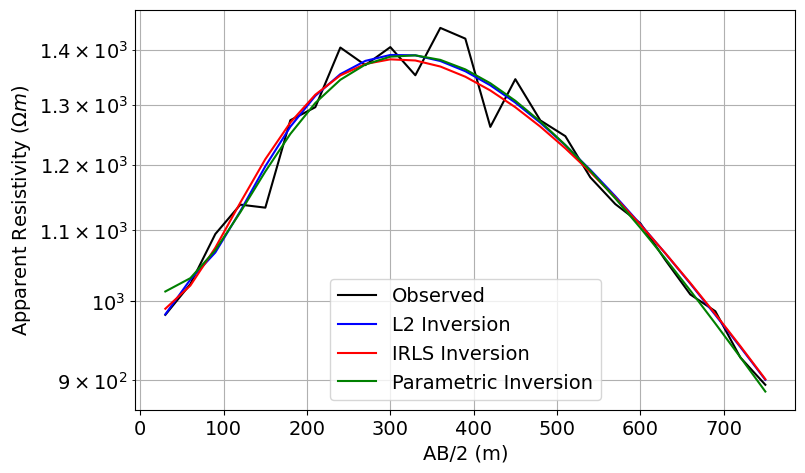

In [44]:
# Plot the true and apparent resistivities on a sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.8])
ax1.semilogy(AB_separations / 2, dobs, "k")
ax1.semilogy(AB_separations / 2, simulation_L2.dpred(recovered_model_L2), "b")
ax1.semilogy(AB_separations / 2, simulation_irls.dpred(recovered_model_irls), "r")
ax1.semilogy(
    AB_separations / 2, simulation_parametric.dpred(recovered_model_parametric), "g"
)
ax1.grid(which="both")
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend(["Observed", "L2 Inversion", "IRLS Inversion", "Parametric Inversion"])
plt.show()

### Plot Recovered Models

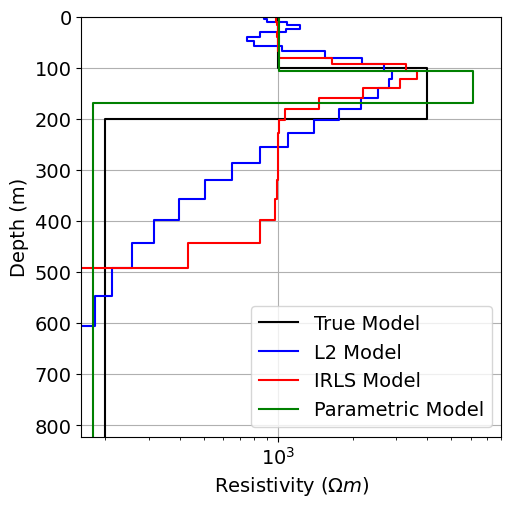

In [45]:
fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
plot_1d_layer_model(true_layers, true_resistivities, ax=ax1, color="k")
plot_1d_layer_model(
    layer_thicknesses, log_resistivity_map * recovered_model_L2, ax=ax1, color="b"
)
plot_1d_layer_model(
    layer_thicknesses, log_resistivity_map * recovered_model_irls, ax=ax1, color="r"
)
plot_1d_layer_model(
    log_thicknesses_map * recovered_model_parametric,
    1 / (log_conductivity_map * recovered_model_parametric),
    ax=ax1,
    color="g",
)
x_min, x_max = true_resistivities.min(), true_resistivities.max()
ax1.set_xlim(0.8 * x_min, 2 * x_max)
ax1.set_ylim([np.sum(layer_thicknesses), 0])
ax1.grid()
ax1.set_xlabel(r"Resistivity ($\Omega m$)")
ax1.legend(["True Model", "L2 Model", "IRLS Model", "Parametric Model"])
plt.show()